In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob

https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [ ]:
import kagglehub
path = kagglehub.dataset_download("tongpython/cat-and-dog")

In [ ]:
from pathlib import Path
path = Path(path)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from random import shuffle

class cats_dogs(Dataset):
  def __init__(self, folder, transform=None, n=9999):
    cats = (folder / "cats").glob("*.jpg")
    dogs = (folder / "dogs").glob("*.jpg")
    self.fpaths = list(cats)[:n] + list(dogs)[:n]
    shuffle(self.fpaths)
    self.targets = [int(f.stem.startswith("dog")) for f in self.fpaths] # dog=1 & cat=0
    self.transform = transform

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    target = self.targets[ix]
    target = np.array(target).astype(np.float32)
    image = cv2.imread(self.fpaths[ix])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if self.transform:
      image = self.transform(image)
    return image, target

In [ ]:
from torchvision.transforms import v2

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),  # 0-255 to 0-1
])

In [ ]:
train_data_dir = path / "training_set" / "training_set"
test_data_dir = path / "test_set" / "test_set"

In [ ]:
data = cats_dogs(train_data_dir, transform=transform)
len(data)

8005

In [ ]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )

def get_model():
    model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 111, 111]         --
│    └─Conv2d: 2-1                       [1, 64, 222, 222]         1,792
│    └─ReLU: 2-2                         [1, 64, 222, 222]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 222, 222]         128
│    └─MaxPool2d: 2-4                    [1, 64, 111, 111]         --
├─Sequential: 1-2                        [1, 512, 54, 54]          --
│    └─Conv2d: 2-5                       [1, 512, 109, 109]        295,424
│    └─ReLU: 2-6                         [1, 512, 109, 109]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 109, 109]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 54, 54]          --
├─Sequential: 1-3                        [1, 512, 26, 26]          --
│    └─Conv2d: 2-9                       [1, 512, 52, 52]          2,359,

In [ ]:
def train_batch(x, y, model, optimizer, loss_fn):
    prediction = model(x).squeeze()
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x).squeeze()
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data(n):
    train = cats_dogs(train_data_dir, transform=transform, n=n)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cats_dogs(test_data_dir, transform=transform, n=9999)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x).squeeze()
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
from tqdm import tqdm

In [ ]:
def train(n):
  trn_dl, val_dl = get_data(n=n)
  model, loss_fn, optimizer = get_model()

  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []
  for epoch in range(5):

      print(epoch)
      train_epoch_losses, train_epoch_accuracies = [], []
      val_epoch_losses, val_epoch_accuracies = [], []
      for ix, batch in tqdm(enumerate(iter(trn_dl)), total=len(trn_dl)):
          x, y = batch
          x, y = x.to(device), y.to(device)
          batch_loss = train_batch(x, y, model, optimizer, loss_fn)
          train_epoch_losses.append(batch_loss)
      train_epoch_loss = np.array(train_epoch_losses).mean()

      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          x, y = x.to(device), y.to(device)
          is_correct = accuracy(x, y, model)
          train_epoch_accuracies.extend(is_correct)
      train_epoch_accuracy = np.mean(train_epoch_accuracies)

      for ix, batch in enumerate(iter(val_dl)):
          x, y = batch
          x, y = x.to(device), y.to(device)
          loss_val = val_loss(x, y, model)
          val_epoch_losses.append(loss_val)
          val_is_correct = accuracy(x, y, model)
          val_epoch_accuracies.extend(val_is_correct)
      validation_loss = np.array(val_epoch_losses).mean()
      val_epoch_accuracy = np.mean(val_epoch_accuracies)

      print(train_epoch_loss)
      print(train_epoch_accuracy)
      print(validation_loss)
      print(val_epoch_accuracy)
      train_losses.append(train_epoch_loss)
      train_accuracies.append(train_epoch_accuracy)
      val_losses.append(validation_loss)
      val_accuracies.append(val_epoch_accuracy)

  return model, (train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
res = {}

In [ ]:
res[500] = train(500)

0


100%|██████████| 31/31 [00:20<00:00,  1.53it/s]


1.0219591336865579
0.6391129032258065
0.6902488176784818
0.5808531746031746
1


100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


0.6390168762976124
0.6945564516129032
0.6787973273368109
0.5798611111111112
2


100%|██████████| 31/31 [00:17<00:00,  1.77it/s]


0.5998272953494903
0.6935483870967742
0.6952097784905207
0.59375
3


100%|██████████| 31/31 [00:17<00:00,  1.80it/s]


0.5560585500732544
0.7409274193548387
0.6610389607293266
0.6205357142857143
4


100%|██████████| 31/31 [00:17<00:00,  1.80it/s]


0.5106720289876384
0.8004032258064516
0.6292943680097186
0.6597222222222222


In [ ]:
res[1000] = train(1000)

0


100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


0.8819309809515553
0.65625
0.6649580569494338
0.5967261904761905
1


100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


0.6118511985386571
0.7227822580645161
0.6257651580704583
0.6721230158730159
2


100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


0.573962454834292
0.7051411290322581
0.643835116946508
0.6393849206349206
3


100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


0.5455813917421526
0.7293346774193549
0.616879663770161
0.6711309523809523
4


100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


0.508930534605057
0.764616935483871
0.624010854297214
0.6845238095238095


In [ ]:
res[2000] = train(2000)

0


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


0.7488908729553223
0.6395
0.6595224019080873
0.6259920634920635
1


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


0.6189497015476226
0.69325
0.6050565006240965
0.689484126984127
2


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


0.579535415649414
0.714
0.5867850014141628
0.6974206349206349
3


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


0.5255607273578644
0.73625
0.5600431722307962
0.7162698412698413
4


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


0.4978745222091675
0.8025
0.48920362951263546
0.7688492063492064


In [ ]:
res[4000] = train(4000)

0


100%|██████████| 250/250 [02:19<00:00,  1.79it/s]


0.6499873151779175
0.719375
0.57042662823011
0.7018849206349206
1


100%|██████████| 250/250 [02:19<00:00,  1.79it/s]


0.5107948042154312
0.803375
0.4464760072647579
0.7931547619047619
2


100%|██████████| 250/250 [02:19<00:00,  1.79it/s]


0.4079022349715233
0.862375
0.36477674212720657
0.8382936507936508
3


100%|██████████| 250/250 [02:19<00:00,  1.79it/s]


0.32261824277043344
0.8915
0.30246365318695706
0.8695436507936508
4


100%|██████████| 250/250 [02:19<00:00,  1.80it/s]


0.24635909739136697
0.90875
0.3060560823669509
0.8665674603174603


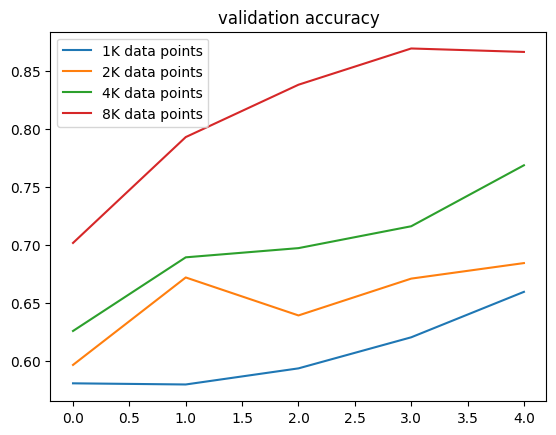

In [ ]:
plt.plot(res[500][1][3], label='1K data points')
plt.plot(res[1000][1][3], label='2K data points')
plt.plot(res[2000][1][3], label='4K data points')
plt.plot(res[4000][1][3], label='8K data points')
plt.legend()
plt.title("validation accuracy")
plt.show()